# Mapping human lymph node cell types to 10X Visium - estimating reference expression signatures

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vitkl/cell2location-sandbox/blob/master/notebooks/scvi_real_data/cell2location_analysis_3_scvi_ln.ipynb)

Cell2location maps cell types by integrating single cell/nucleus and spatial transcriptomics data. This is achieved by estimating which combination of cell types in which cell abundance could have given the mRNA counts in the spatial data, taking technical effects into account (platform/technology effect, contaminating RNA, unexplained variance).

Given cell type annotation for each cell, the corresponding reference cell type signatures $g_{f,g}$, which represent the average mRNA count of each gene $g$ in each cell type $f={1, .., F}$, can be estimated from sc/snRNA-seq data using 2 provided methods (see below). Cell2location needs untransformed unnormalised spatial mRNA counts as input. You also need to provide cell2location with the expected average cell abundance per location which is used as a prior to guide estimation of absolute cell abundance. This value depends on the tissue and can be estimated by counting nuclei for a few locations in the paired histology image but can be approximate (see paper methods for more guidance).

We provide 2 methods for estimating reference expression signatures of cell types from scRNA-seq data:

1) a statistical method based on Negative Binomial regression. We generally recommend using NB regression, which allows to robustly combine data across technologies and batches, which results in improved spatial mapping accuracy. This notebook shows use a dataset composed on multiple batches and technologies to estimate that. 

2) hard-coded computation of per-cluster average mRNA counts for individual genes (`scvi.external.cell2location.compute_cluster_averages`). When the batch effects are small, this faster hard-coded method of computing per cluster averages provides similarly high accuracy. We also recommend the hard-coded method for non-UMI technologies such as Smart-Seq 2.


### Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load refence cell type expression signatures](#Loading_signatures)
* [Run scvi-cell2location](#cell2location)
* [Leiden clustering of cell abundance](#region_clustering)




### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "pyro-cell2location"
user = "vitkl"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/$user/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
import sys
if not IN_COLAB:
    sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

#import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output.

In [3]:
results_folder = './results/lymph_nodes_analysis/'
scvi_run_name = f'{results_folder}/amortised/v1'

adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Load reference cell type expression signatures <a class="anchor" id="Loading_signatures"></a>

The signatures were estimated from scRNA-seq data, accounting for batch effect, using a separate model, as shown here: https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_estimating_signatures.html

Here we download the h5ad object with results:

In [4]:
import os
if not os.path.exists('./data/sc.h5ad'):
    !cd ./data/ && wget https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad 

In [5]:
# read data
adata_snrna_raw = sc.read(f'./data/sc.h5ad')

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_snrna_raw, batch_key='Sample', labels_key='Subset')
scvi.data.view_anndata_setup(adata_snrna_raw)

INFO     Using batches from adata.obs["Sample"]                                              
INFO     Using labels from adata.obs["Subset"]                                               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/ca

INFO     Successfully registered anndata object containing 73260 cells, 10237 vars, 23       
         batches, 34 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  warnings.warn(*args, **kwargs)


Epoch 100/100: 100%|██████████| 100/100 [09:41<00:00,  5.81s/it, v_num=1, train_loss_step=2.8e+8, train_loss_epoch=2.79e+8] 


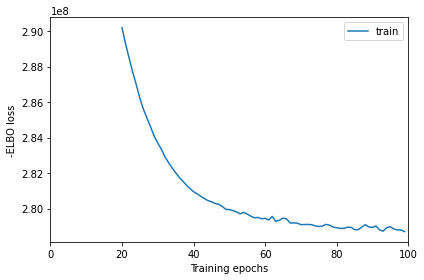

In [6]:
# create and train the model
from scvi.external.cell2location._reference_module import RegressionModel
mod = RegressionModel(
    adata_snrna_raw,
    batch_size=2500, 
    amortised=True, single_encoder=True,
    encoder_kwargs={'dropout_rate': 0.2},
    #init_vals = {'per_cluster_mu_fg': per_cluster_mu_fg}
) 

mod.train(max_epochs=100, lr=0.01, use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(20)

In [7]:
# In this section, we save the summary of the posterior distribution of bursting rates.
scvi_run_name = results_folder + 'regression_model/scvi_v1'

# generate samples from posterior distributions for all parameters 
# and compute mean, 5%/95% quantiles and standard deviation
samples = mod.sample_posterior(num_samples=1000, use_gpu=True)

# export posterior distribution summary for all parameters and 
# annotation (model, date, var, obs and cell type names) to anndata object
adata_snrna_raw.uns['mod'] = mod.export2adata(samples)

# add estimated average expression as pd.DataFrames to obsm in anndata
# first convert np.arrays to pd.DataFrames with cell type and variable names 
# data frames contain mean, 5%/95% quantiles and standard deviation, denoted by a prefix
sample_df_dict = mod.sample2df_vars(samples, site_name="per_cluster_mu_fg", name_prefix='')
for k, df in sample_df_dict.items():
    #adata_snrna_raw.var[df.columns] = df.loc[adata_snrna_raw.var.index, :] # <- not sure if this is better than obsm
    adata_snrna_raw.varm[k] = df.loc[adata_snrna_raw.var.index, :]
    
#sample_df_dict = mod.sample2df_obs(samples, site_name="detection_y_c", name_prefix='')
#for k, df in sample_df_dict.items():
#    adata_snrna_raw.obs[df.columns] = df.loc[adata_snrna_raw.obs.index, :] # <- not sure if this is better than obsm
#    #adata_snrna_raw.obsm[k] = df.loc[adata_snrna_raw.obs.index, :]

# Save model
mod.save(f"{scvi_run_name}", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.Cell2location.load(f"{scvi_run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{scvi_run_name}/sp.h5ad"
adata_snrna_raw.write(adata_file)
adata_file

Sampling local variables, batch:   0%|          | 0/30 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

'./results/lymph_nodes_analysis/regression_model/scvi_v1/sp.h5ad'

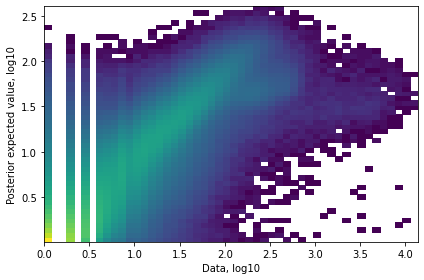

In [8]:
# examine reconstruction accuracy to assess if there are any issues with inference
nb_parameters = mod.module.model.compute_expected(samples['post_sample_means'], adata_snrna_raw)
mod.plot_posterior_mu_vs_data(nb_parameters['mu'], adata_snrna_raw.X.toarray())

The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

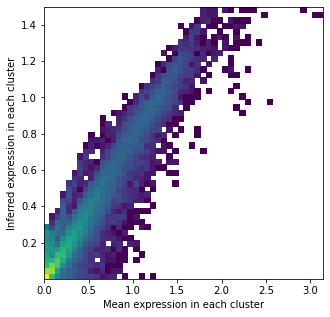

In [9]:
inf_aver = adata_snrna_raw.varm['mean_per_cluster_mu_fg']

# compute mean expression of each gene in each cluster
aver = scvi.external.cell2location.compute_cluster_averages(adata_snrna_raw, 'Subset')
from re import sub
inf_aver.columns = [sub('mean_per_cluster_mu_fg', '', i) for i in inf_aver.columns]
aver = aver.loc[:, inf_aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=mpl.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

In [10]:
samples['post_sample_means']['detection_y_c'].shape

(73260, 1)

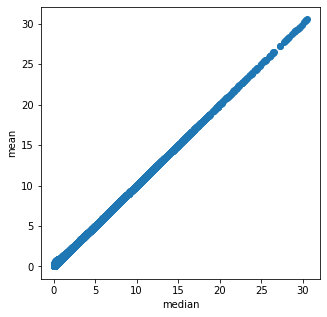

In [11]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, use_gpu = True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['per_cluster_mu_fg'].flatten(),
                samples['post_sample_means']['per_cluster_mu_fg'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');

In [12]:
inf_aver

,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN,B_activated,B_mem,B_naive,B_plasma,B_preGC,...,T_CD4+_TfH,T_CD4+_TfH_GC,T_CD4+_naive,T_CD8+_CD161+,T_CD8+_cytotoxic,T_CD8+_naive,T_TIM3+,T_TfR,T_Treg,VSMC
NOC2L,0.161488,0.122564,0.151123,0.173819,0.084727,0.101662,0.084957,0.090299,0.116330,0.183254,...,0.080812,0.081542,0.102542,0.080890,0.076230,0.124494,0.139556,0.093423,0.094790,0.167392
HES4,0.001593,0.001070,0.001060,0.028092,0.021639,0.009430,0.018003,0.005348,0.002005,0.011309,...,0.032512,0.021923,0.038044,0.011503,0.004869,0.014193,0.070718,0.214366,0.039745,1.195686
ISG15,0.152731,0.122380,0.148117,0.290065,2.370844,0.084799,0.126665,0.087653,0.170060,0.066937,...,0.159221,0.241301,0.201282,0.194895,0.236486,0.246575,0.895547,0.359688,0.208844,0.289800
TNFRSF18,0.008941,0.001673,0.031508,0.037623,0.007118,0.003538,0.002945,0.001276,0.083323,0.081873,...,0.011603,0.193594,0.003098,0.038602,0.010298,0.001254,0.136847,0.589498,0.247331,0.030627
TNFRSF4,0.005379,0.000966,0.006014,0.017460,0.006666,0.002077,0.003837,0.001996,0.051032,0.034206,...,0.092881,0.399999,0.022382,0.039867,0.013410,0.002332,0.181888,1.115934,0.480265,0.032504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGL_VDJsum,8.186493,9.295385,4.407541,4.436318,3.440782,7.000300,3.005826,1.796644,28.388092,4.218672,...,0.007444,0.009350,0.008614,0.013546,0.042379,0.015437,0.060648,0.017676,0.009625,0.103795
TCRA_VDJsum,0.020394,0.004561,0.010737,0.050776,0.004086,0.004162,0.002521,0.000987,0.045949,0.005868,...,1.278881,2.287307,1.308158,0.902553,1.405334,1.381775,2.498550,2.699687,1.770735,0.285224
TCRB_VDJsum,0.038428,0.003186,0.005364,0.011552,0.011794,0.006532,0.007250,0.005731,0.108960,0.005417,...,2.521174,8.674041,2.864871,1.390127,2.986181,2.770799,6.040985,9.333780,3.471623,0.193882
TCRD_VDJsum,0.000885,0.002747,0.002404,0.338586,0.047394,0.001041,0.000541,0.000465,0.004645,0.010609,...,0.015681,0.016467,0.015566,0.101425,0.058729,0.031046,0.065056,0.019912,0.016555,0.547304


## Train scvi-cell2location <a class="anchor" id="scvi-cell2location"></a>

In [ ]:
# rename genes to ENSEMBL
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var_names = adata_vis.var['gene_ids']
adata_vis.var_names.name = None

In [ ]:
# find shared genes and subset both anndata and reference signatures
adata_vis, inf_aver = scvi.external.cell2location.intersect_var(
    adata=adata_vis, cell_state_df=inf_aver)

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
scvi.data.view_anndata_setup(adata_vis)

In [ ]:
# create and train the model
mod = scvi.external.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    batch_size=2020, 
    amortised=True, single_encoder=True,
    encoder_kwargs={'dropout_rate': 0.2},
    # the expected average cell abundance - user-provided, tissue-dependent hyper-prior:
    N_cells_per_location=30) 

mod.train(max_epochs=1000, lr=0.01, use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(100)
plt.legend(labels=['minibatch 2020/4039']);

In [ ]:
# In this section, we save the summary of the posterior distribution of cell abundance.

# generate samples from posterior distributions for all parameters 
# and compute mean, 5%/95% quantiles and standard deviation
samples = mod.sample_posterior(num_samples=1000, use_gpu=True)

# export posterior distribution summary for all parameters and 
# annotation (model, date, var, obs and cell type names) to anndata object
adata_vis.uns['mod'] = mod.export2adata(samples)

# add estimated cell abundance as dataframe to obsm in anndata
# first convert np.arrays to pd.DataFrames with cell type and observation names 
# data frames contain mean, 5%/95% quantiles and standard deviation, denoted by a prefix
sample_df_dict = mod.sample2df(samples, site_name="w_sf", name_prefix='cell_abundance_')
for k, df in sample_df_dict.items():
    #adata_vis.obs[df.columns] = df.loc[adata_vis.obs.index, :] # <- not sure if this is better than obsm
    adata_vis.obsm[k] = df.loc[adata_vis.obs.index, :]

# Save model
mod.save(f"{scvi_run_name}", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.Cell2location.load(f"{scvi_run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{scvi_run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

In [ ]:
# examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
nb_parameters = mod.module.model.compute_expected(samples['post_sample_means'], adata_vis)
mod.plot_posterior_mu_vs_data(nb_parameters['mu'], adata_vis.X.toarray())

### Plot cell abundance in spatial coordinates

In [ ]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, cmap='magma',
                  color=adata_vis.uns['mod']['factor_names'], # show all cell types
                  ncols=4, size=1.3, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2' 
                 )

## Perform clustering of cell abudance estimates to identify tissue regions <a class="anchor" id="region_clustering"></a>

We find regions by clustering locations/spots (Leiden) based on estimated cell abundance of each cell type. Results are saved in `adata_vis.obs['region_cluster']`.

In [13]:
# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 20)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster"] =  adata_vis.obs["region_cluster"].astype("category")

In [ ]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'], 
                  size=1.3, img_key='hires', alpha=0.5)

### Advanced use examples

In [ ]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)

In [ ]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, use_gpu = True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');

Modules and their versions used for this analysis

In [23]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.20.0
IPython.core.release 7.20.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.4
pexpect 4.8.0
ptyprocess 0.7.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.0
parso 0.8.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.9
scanpy 1.7.0
scanpy._metadata 1.7.0
packaging 20.9
packaging.__about__ 20.9
importlib_metadata 1.7.0
csv 1.0
_csv 1.0
numpy 1.20.0
numpy.core 1.20.0
numpy.core._multiarray_umath 3.1
numpy.lib 1.20.0
numpy.linalg.